In [1]:
from scipy import (signal, ndimage)
import numpy as np, cv2
import matplotlib.pyplot as plt

In [2]:
ker_ellipse = lambda ks: cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks,ks))

class hcon_delimeter:

    def __init__(self, images_list, delimeter_width = 1, border_width = 1,fill_value = 0):
        self.imgs           = images_list
        self.dw             = delimeter_width
        self.fw             = fill_value
        self.im_shape       = images_list[0].shape
        self.im_dtype       = images_list[0].dtype
        self.channels_num   = len(self.im_shape)
        # 
        self.delimeter      = self.get_delimeter()
        imgs_del            = self.interleave_delimeter()
        self.hconcat        = cv2.hconcat(imgs_del)
        self.add_border(border_width,fill_value)


    def get_delimeter(self):
        if self.channels_num == 3:
            delimeter_shape = (self.im_shape[0], self.dw, 3)
        else:
            delimeter_shape = (self.im_shape[0], self.dw )

        return np.full(shape = delimeter_shape, fill_value = self.fw, dtype = self.im_dtype)

    def interleave_delimeter(self):
        out_arr = []
        for img in self.imgs:
            out_arr.append(img)
            out_arr.append(self.delimeter)
        return out_arr[:-1]

    def add_border(self, border_width = 5, color = 0):
        if border_width > 0:
            HWC_offset = np.zeros(self.channels_num, int)   
            HWC_offset[:2] = 2*border_width 
            # new_shape = [H,W,0] + [2*bw,2*bw,0]
            shape_big = np.array(self.hconcat.shape) + HWC_offset

            blank = np.full(shape_big, color, dtype = self.im_dtype)
            blank[border_width:-border_width,border_width:-border_width] = self.hconcat

            self.hconcat = blank

    def ret(self):
        return self.hconcat
    
a = np.array([   [1,1],
                    [1,1]   ])*255

#a = np.ones((2,2,3))*255
# hcon = hcon_delimeter(images_list = [a,a], delimeter_width=1,border_width=0)
# hcon.add_border(1,128)
# plt.imshow(hcon.ret())



# Basic principle of correlation operation:
Kernel is scanned across a matrix and at each sample point operation then computes sum of matrix element-wise products. Here is an example

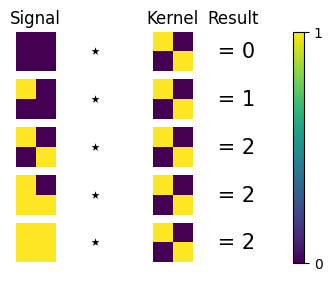

In [3]:
ptrn = np.array([   [1,0],
                    [0,1]   ])

signals = np.array([[[0,0],[0,0]],
                    [[1,0],[0,0]],
                    [[1,0],[0,1]],
                    [[1,0],[1,1]],
                    [[1,1],[1,1]],],dtype = np.uint8)

fig, ax = plt.subplots(signals.shape[0], 4, figsize=(4, 3))#, layout='constrained'

for i, img in enumerate(signals):
    res = signal.correlate(img, ptrn, mode='valid').flatten()[0]
    cax = ax[i,0].imshow(img, vmin=0, vmax=1)
    ax[i,1].text(0.5, 0.5, r'$\star$ ', ha="center", size=15, va='center')
    cax = ax[i,2].imshow(ptrn, vmin=0, vmax=1)
    ax[i,3].text(0.5, 0.5, ' = '+str(res), ha="center", size=15, va='center')
    for j in range(4):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('off')

[ax[0,i].set_title(tit) for i,tit in enumerate(['Signal','','Kernel','Result'])]

cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_ticks([ 0, 1])

Notice that last 3 signals produce same result. Its because products 1\*0 = 0 dont contribute into total sum. <br>
 _As a curious sidenote, you can change kernel so unwanted overlaps are penalized: change kernel's zeros to negative values, so 1*(-a) = -a will lower total sum_

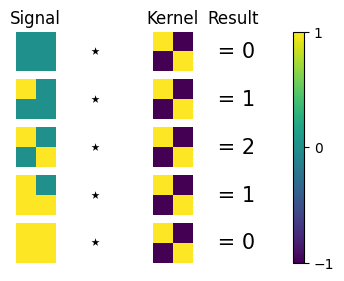

In [4]:
a = -1
ptrn2 =np.array([   [1,a],
                    [a,1]   ])

res = [signal.correlate(img, ptrn2, mode='valid').flatten()[0] for img in signals]
vmin,vmax = np.min(ptrn2), np.max(ptrn2)
fig, ax = plt.subplots(signals.shape[0], 4, figsize=(4, 3))#, layout='constrained'
for i, img in enumerate(signals):
    cax = ax[i,0].imshow(img, vmin=vmin, vmax=vmax)
    ax[i,1].text(0.5, 0.5, r'$\star$ ', ha="center", size=15, va='center')
    cax = ax[i,2].imshow(ptrn2, vmin=vmin, vmax=vmax)
    ax[i,3].text(0.5, 0.5, ' = '+str(res[i]), ha="center", size=15, va='center')
    for j in range(4):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('off')
[ax[0,i].set_title(tit) for i,tit in enumerate(['Signal','','Kernel','Result'])]
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_ticks([-1, 0, 1])

# Use correlation to find segment of data inside larger data
If some portion of data is hidden in larger chunk of data, it can be found by cross-correlation of searched data segment across whole data.

_when performing correlation with mode='full' it allows to find partial overlaps on edges (outside of domain like photo panorama)_

In this example i generate sample data if shape (W,H), place it in other data of larger shape with a known offset, and add some noise on top of it.

Using correlation you can extract position of inserted sample data.

true offset:  [5, 13]
found offset:  [ 5 13]


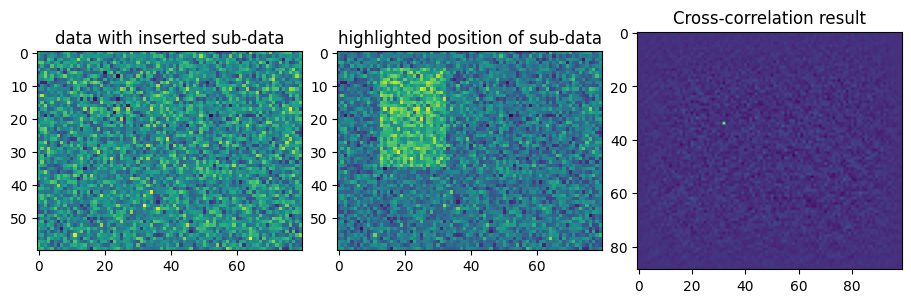

In [5]:
np.random.seed(69)

sub_shape = (30,20)
sub = np.random.randn(*sub_shape)
W,H = np.array(sub.shape)

# insert sub data inside other data
X = 5;Y = 13
print('true offset: ',[X,Y])
blank = np.random.randn(W + 30,H + 60)

blank[X:X+W,Y:Y+H] = sub
blank += 1*np.random.randn(*blank.shape)
# copy blank to mark position of sub data
blank_copy = blank.copy()
blank_copy[X:X+W,Y:Y+H] += 3
# scan sub over whole data, mode full is used to find sub that is partially outside blank
corr1 = signal.correlate(blank, sub, mode='full')

match_xy = np.array(np.unravel_index(np.argmax(corr1, axis=None), corr1.shape))
match_xy_true = match_xy - [W,H] + 1

print('found offset: ', match_xy_true)

fig, ax = plt.subplots(1, 3, figsize=(9, 9), layout='constrained')
ax[0].imshow(blank)
ax[0].set_title('data with inserted sub-data')
ax[1].imshow(blank_copy)
ax[1].set_title('highlighted position of sub-data')
ax[2].imshow(corr1)
ax[2].set_title('Cross-correlation result');


***
# Example with repositioned text
If data is periodic and/or very similar, it will be hard to pinpoint location.

Can try to do a trick with replacing kernel 0-s with negative numbers to force overlap of better quality

In [6]:
lnk1 = r'../media/corr_top.png'
lnk2 = r'../media/corr_bottom.png'
blank   = cv2.imread(lnk1, flags=cv2.IMREAD_GRAYSCALE)/255
ker    = cv2.imread(lnk2, flags=cv2.IMREAD_GRAYSCALE)/255
ker = ker[:120,:60] # larger image sticks out too much, cannot dampen unwanted overlaps
W,H = np.array(ker.shape)
W0,H0 = np.array(blank.shape)

blank_th = cv2.threshold(blank, 90/255, 1, cv2.THRESH_BINARY)[1]
ker_th = cv2.threshold(ker,  90/255, 1, cv2.THRESH_BINARY)[1]

ker_th_mod = ker_th.copy()
a = 4
ker_th_mod = ker_th_mod * a - (a - 1)

corr1 = signal.correlate(blank_th, ker_th, mode='full')
corr2 = signal.correlate(blank_th, ker_th_mod, mode='full')

found offset:  88 1
found offset:  155 1


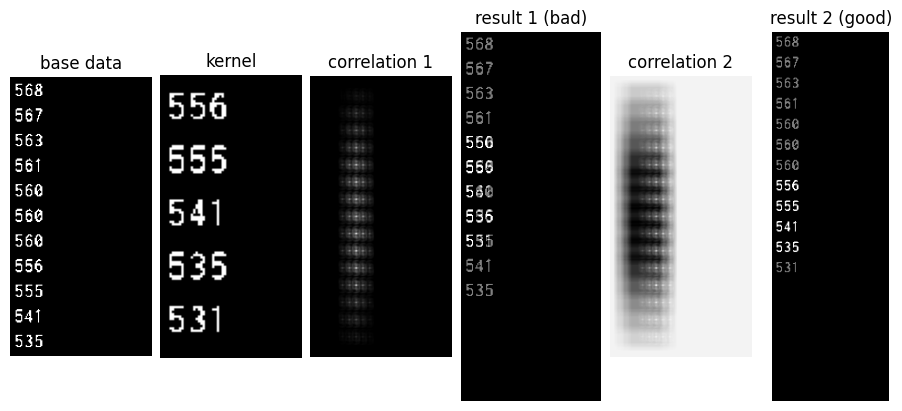

In [7]:
fig, ax = plt.subplots(1, 6, figsize=(9, 4), layout='constrained')

ax[0].imshow(blank_th   , 'gray')
ax[1].imshow(ker_th     , 'gray')

for i, corr in enumerate([corr1,corr2]):
    match_xy = np.array(np.unravel_index(np.argmax(corr, axis=None), corr.shape))
    m_x_true,m_y_true = match_xy - [W,H] + 1
    print('found offset: ', m_x_true, m_y_true)

    bs = np.zeros((m_x_true + max(W,W0), m_y_true + max(H,H0)), float) 
    bs[:W0,:H0] += blank_th/2
    bs[m_x_true :m_x_true + W , m_y_true :m_y_true+H] += ker_th/2

    ax[2*i+0+ 2].imshow(corr, 'gray')
    ax[2*i+1+ 2].imshow(bs  , 'gray')

titles = ['base data', 'kernel', 'correlation 1', 'result 1 (bad)','correlation 2', 'result 2 (good)']
for a,t in zip(ax,titles):
    a.axis('off')
    a.set_title(t)